In [ ]:
!nvidia-smi

Wed Aug 25 09:42:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |   1174MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TEST_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/AgeDB/csv/AgeDB_final_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH_TEST = '/content/drive/MyDrive/CSE465/datasets/AgeDB/AgeDB-images/'

RANDOM_SEED = 42 # 0,1,2
# MODEL_NAME = "UTK-CE_ResNet34_100%"
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/UTK-CE_ResNet34_100%-class-97'
NUM_CLASSES = 97
BATCH_SIZE = 256
GRAYSCALE = False
NUM_WORKERS = 0
random_weights = False

In [ ]:
# GPU or CPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'evaluation_AgeDB.log')

In [ ]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
# header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Random Weights in Output Layer: {random_weights}')
header.append(f'\n-------------------EVALUATION RESULTS---------------')

In [ ]:
for entry in header:
  print(entry)




Last Run: 2021-08-25 15:42:45.558284+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/UTK-CE_ResNet34_100%-class-97
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 256
Grayscale: False
Random Weights in Output Layer: False

-------------------EVALUATION RESULTS---------------


In [ ]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [ ]:
df = pd.read_csv(TEST_CSV_PATH, index_col=1)
df

,file,label
age,,
35,0_MariaCallas_35_f.jpg,33
40,1_MariaCallas_40_f.jpg,38
28,10_MariaCallas_28_f.jpg,26
52,100_PaulAnka_52_m.jpg,50
1,1000_StephenHawking_1_m.jpg,0
...,...,...
54,9995_GlennClose_54_f.jpg,52
56,9996_GlennClose_56_f.jpg,54
58,9997_GlennClose_58_f.jpg,56


In [ ]:
class AgeDBDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:
custom_transform_test = transforms.Compose([transforms.Resize((128, 128)),
                                        transforms.CenterCrop((120, 120)),
                                        transforms.ToTensor()])

test_dataset = AgeDBDataset(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH_TEST,
                              transform=custom_transform_test,
                              items = None)

In [ ]:
len(test_dataset)

16347

# Dataset Entity Distribution Analysis

In [ ]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

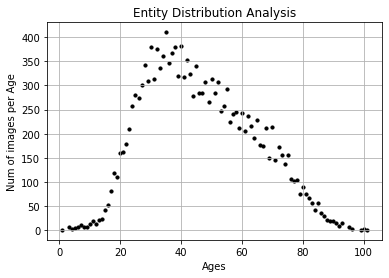

label		Age		Count
0 		 1 		 1
1 		 3 		 8
2 		 4 		 2
3 		 5 		 4
4 		 6 		 8
5 		 7 		 11
6 		 8 		 8
7 		 9 		 6
8 		 10 		 13
9 		 11 		 20
10 		 12 		 14
11 		 13 		 22
12 		 14 		 23
13 		 15 		 43
14 		 16 		 52
15 		 17 		 82
16 		 18 		 119
17 		 19 		 110
18 		 20 		 161
19 		 21 		 163
20 		 22 		 179
21 		 23 		 209
22 		 24 		 257
23 		 25 		 281
24 		 26 		 274
25 		 27 		 301
26 		 28 		 343
27 		 29 		 310
28 		 30 		 380
29 		 31 		 313
30 		 32 		 376
31 		 33 		 336
32 		 34 		 361
33 		 35 		 410
34 		 36 		 346
35 		 37 		 368
36 		 38 		 380
37 		 39 		 320
38 		 40 		 381
39 		 41 		 318
40 		 42 		 353
41 		 43 		 323
42 		 44 		 279
43 		 45 		 340
44 		 46 		 285
45 		 47 		 285
46 		 48 		 308
47 		 49 		 265
48 		 50 		 314
49 		 51 		 285
50 		 52 		 308
51 		 53 		 248
52 		 54 		 257
53 		 55 		 292
54 		 56 		 225
55 		 57 		 240
56 		 58 		 245
57 		 59 		 211
58 		 60 		 243
59 		 61 		 205
60 		 62 		 236
61 		 63 		 217
62 		 64 		 192
63 		 65 		 229

In [ ]:
dataset_analysis(test_dataset)

# Dataset Loader

In [ ]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [ ]:
print(f"No. of Batches for AgeDB: {len(test_loader)}")

No. of Batches for AgeDB: 64


# Model

### ResNet34

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

`nn.RELU(inplace=True)` [details](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948)

Understanding the underscore( _ ) of Python [link](https://stackoverflow.com/questions/8689964/why-do-some-functions-have-underscores-before-and-after-the-function-name)

`self.modules()` [link](https://discuss.pytorch.org/t/pytorch-self-module/49677)

What do `*` and `**` before a variable name mean in a function signature? [link](https://stackoverflow.com/questions/11315010/what-do-and-before-a-variable-name-mean-in-a-function-signature)

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1) # reshaping, -1 means calculate the suitable number for second dimension 
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

# Initialize Model, and Optimizer

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

"""Preparaing the model to evaluate on AgeDB"""
model = resnet34(NUM_CLASSES, GRAYSCALE)
model.load_state_dict(torch.load(os.path.join(PATH, 'model.pt')))
# print(model.fc.weight.data)
# if random_weights:
#   model.fc = nn.Linear(model.fc.in_features, 101)
# print(model.fc.weight.data)
model.to(DEVICE)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Evaluation

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(tqdm(data_loader)):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)

    _, predicted_labels = torch.max(probas, dim=1)
    # predicted_labels = probas > 0.5
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

# Testing on AgeDB

In [ ]:
start_time = time.time()
model.eval()
with torch.set_grad_enabled(False):
  test_mae, test_mse, test_acc = compute_mae_and_mse(model, test_loader, device=DEVICE)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'MAE/RMSE/ACC: | AGEDB-Test: {test_mae}/{test_mse}/{test_acc}%\n'
  str2 = f'Time elapsed: {time_elapsed}mins \n'
  str = str1 + str2
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}\n')